# Logistic Regression Model

## Data Import And Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
from sklearn.preprocessing import StandardScaler

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

test_files = ['../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']
x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 0

In [3]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


In [4]:
test_dfs[test_index].head()

,Time America/Boise UTC-06:00,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,4/11/2018 10:30,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6
1,4/11/2018 10:45,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6
2,4/11/2018 11:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7
3,4/11/2018 11:15,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7
4,4/11/2018 11:30,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7


In [5]:
train_dfs[train_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000
mean,18.488235,1933.564575,-116.806951,8.633415,58.129348,87.056980,8.179008,0.979511
std,6.134464,151.800551,8.973830,0.147231,54.622278,13.793755,1.278416,0.731423
min,5.630000,3.000000,-153.700000,7.930000,0.660000,62.800000,5.170000,0.000000
25%,12.700000,1848.000000,-120.800000,8.530000,29.850000,80.000000,7.260000,0.500000
50%,20.320000,1939.000000,-115.700000,8.650000,42.140000,83.200000,8.080000,0.900000
75%,23.630000,2070.000000,-112.100000,8.700000,65.795000,88.900000,9.250000,1.200000
max,28.570000,2164.000000,-76.500000,9.230000,636.700000,209.700000,16.170000,16.100000


In [6]:
test_dfs[test_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000
mean,19.131184,1990.294607,-196.624329,8.922357,63.929067,90.057202,8.309566,1.459773
std,5.045367,230.743946,27.769024,0.357733,70.885989,17.627283,1.486747,1.311960
min,0.000000,0.000000,-284.000000,0.000000,-0.880000,0.000000,0.000000,-0.400000
25%,15.480000,1869.000000,-216.950000,8.730000,33.750000,79.100000,7.280000,0.600000
50%,20.190000,1958.000000,-192.000000,8.920000,48.380000,85.300000,8.010000,1.000000
75%,23.070000,2149.000000,-179.500000,9.100000,68.275000,95.300000,9.240000,1.700000
max,28.600000,2417.000000,0.000000,10.100000,1248.920000,245.500000,19.590000,21.100000


## Use Datetime Index

In [7]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [8]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [9]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


## Fill missing values

In [10]:
# Fill all missing values with the mean
for df in test_dfs + train_dfs:
    for column in df.columns:
        number_null = np.sum(df[column].isnull())
        column_length = len(df[column])
        print('{} percent null: {:.1f}%'.format(
            column, (number_null / column_length) * 100))
        if number_null > 0:
            print("Filling {} with mean: {}\n".format(column, df[column].mean()))
            df[column] = df[column].fillna(df[column].mean()) 

Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 0.0%
ODOSat% percent null: 0.0%
ODO (mg/L) percent null: 0.0%
BGA-Phycocyanin RFU percent null: 0.0%
datetime percent null: 0.0%
Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 0.0%
ODOSat% percent null: 0.0%
ODO (mg/L) percent null: 0.0%
BGA-Phycocyanin RFU percent null: 0.0%
datetime percent null: 0.0%
Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 0.0%
ODOSat% percent null: 0.0%
ODO (mg/L) percent null: 0.0%
BGA-Phycocyanin RFU percent null: 0.0%
datetime percent null: 0.0%
Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 3.2%
Filling Turbidity (NTU) with mean: 64.9625066543

## Extract Windows

In [11]:
presegmented_plot = pd.DataFrame(
    {'BGA RFU': train_dfs[train_index][target_column], 
     'Bloom Threshold': np.full(train_dfs[train_index].count()[0], RFU_THRESHOLD)})

In [12]:
# Segment each data frame
for i in range(0, len(train_dfs)):
    print("Windowizing 2017 data set:", i)
    train_dfs[i] = hf.data_window_reduction(
        train_dfs[i], 'datetime', target_column)
    print("Windowizing 2018 data set:", i)
    test_dfs[i] = hf.data_window_reduction(
        test_dfs[i], 'datetime', target_column)
    print()

Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Windowizing 2017 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



## Bucket/Bin Features

### Bin all numerical data

In [13]:
# add binned categories
bins = 4
drop_columns = []
new_columns = []
quantile_binning = False
for i in range(0, len(train_dfs)):
    train_dfs[i]
    temp = train_dfs[i][x_columns].drop(columns=drop_columns)
    binned, b_cols = hf.bin_df(temp, bins, quantile_binning)
    new_columns += b_cols
    train_dfs[i] = pd.concat([train_dfs[i], binned], axis='columns')
    
# add binned categories for testing sets
for i in range(0, len(test_dfs)):
    test_dfs[i]
    temp = test_dfs[i][x_columns].drop(columns=drop_columns)
    binned, b_cols = hf.bin_df(temp, bins, quantile_binning)
    new_columns += b_cols
    test_dfs[i] = pd.concat([test_dfs[i], binned], axis='columns')
test_dfs[test_index].dtypes

BGA-Phycocyanin RFU              float64
ODO (mg/L)                       float64
ODOSat%                          float64
Sp Cond (uS/cm)                  float64
Temp C                           float64
Turbidity (NTU)                  float64
datetime                  datetime64[ns]
pH                               float64
pH (mV)                          float64
Temp C_4_bins                   category
Sp Cond (uS/cm)_4_bins          category
pH (mV)_4_bins                  category
pH_4_bins                       category
Turbidity (NTU)_4_bins          category
ODOSat%_4_bins                  category
ODO (mg/L)_4_bins               category
dtype: object

In [14]:
# Add the new columns to x columns
x_columns = list(set(x_columns + new_columns))
print(x_columns)

['Turbidity (NTU)_4_bins', 'pH', 'ODOSat%', 'ODOSat%_4_bins', 'pH (mV)', 'ODO (mg/L)_4_bins', 'Temp C_4_bins', 'ODO (mg/L)', 'Turbidity (NTU)', 'pH_4_bins', 'Sp Cond (uS/cm)', 'Sp Cond (uS/cm)_4_bins', 'Temp C', 'pH (mV)_4_bins']


## Plots of Variables

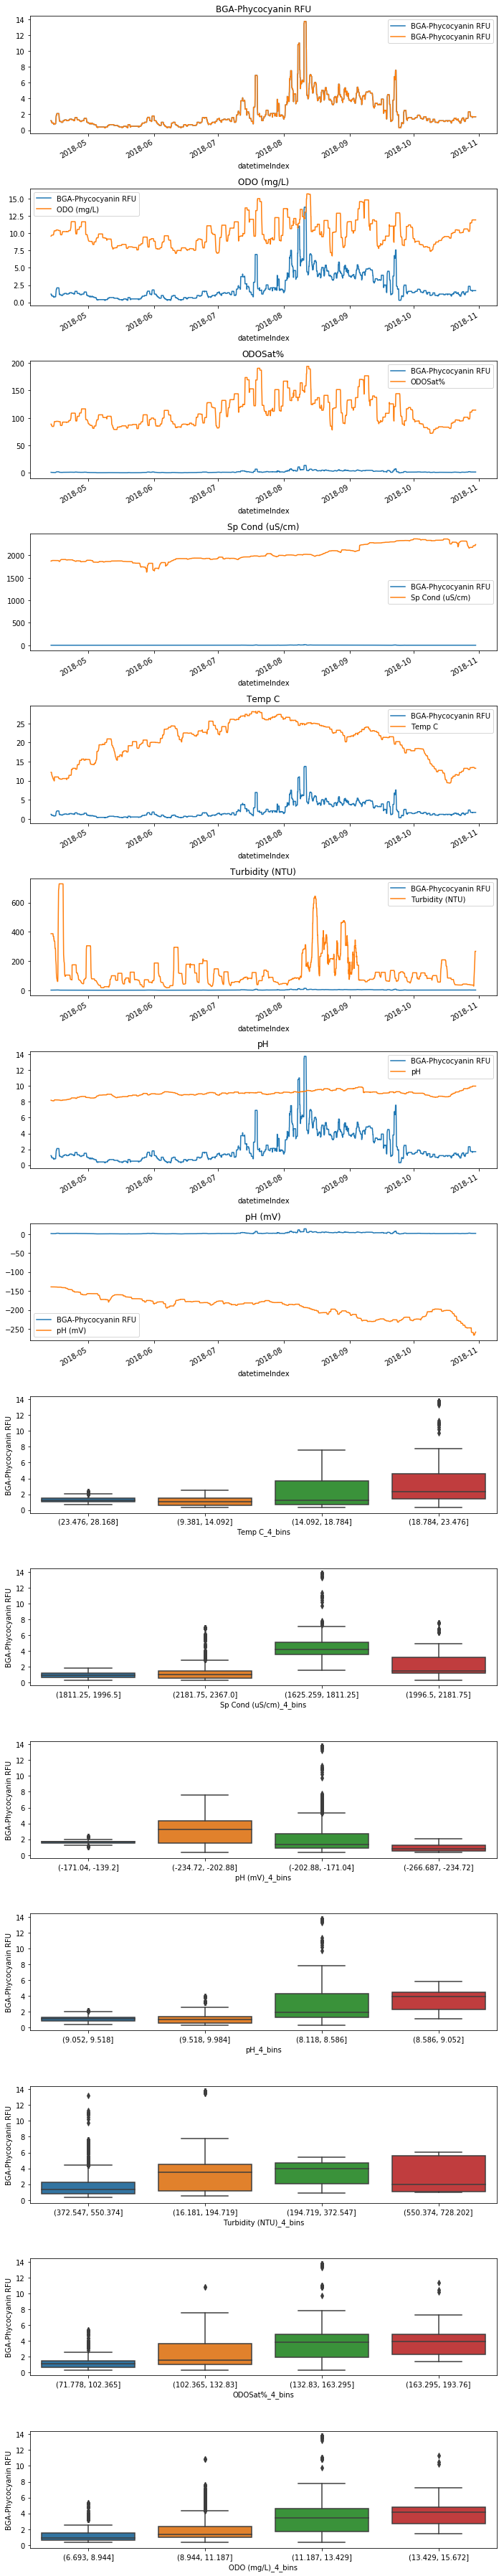

In [15]:
hf.create_plots(test_dfs[test_index].drop(columns=['datetime']), target_column)

## Correlation plots

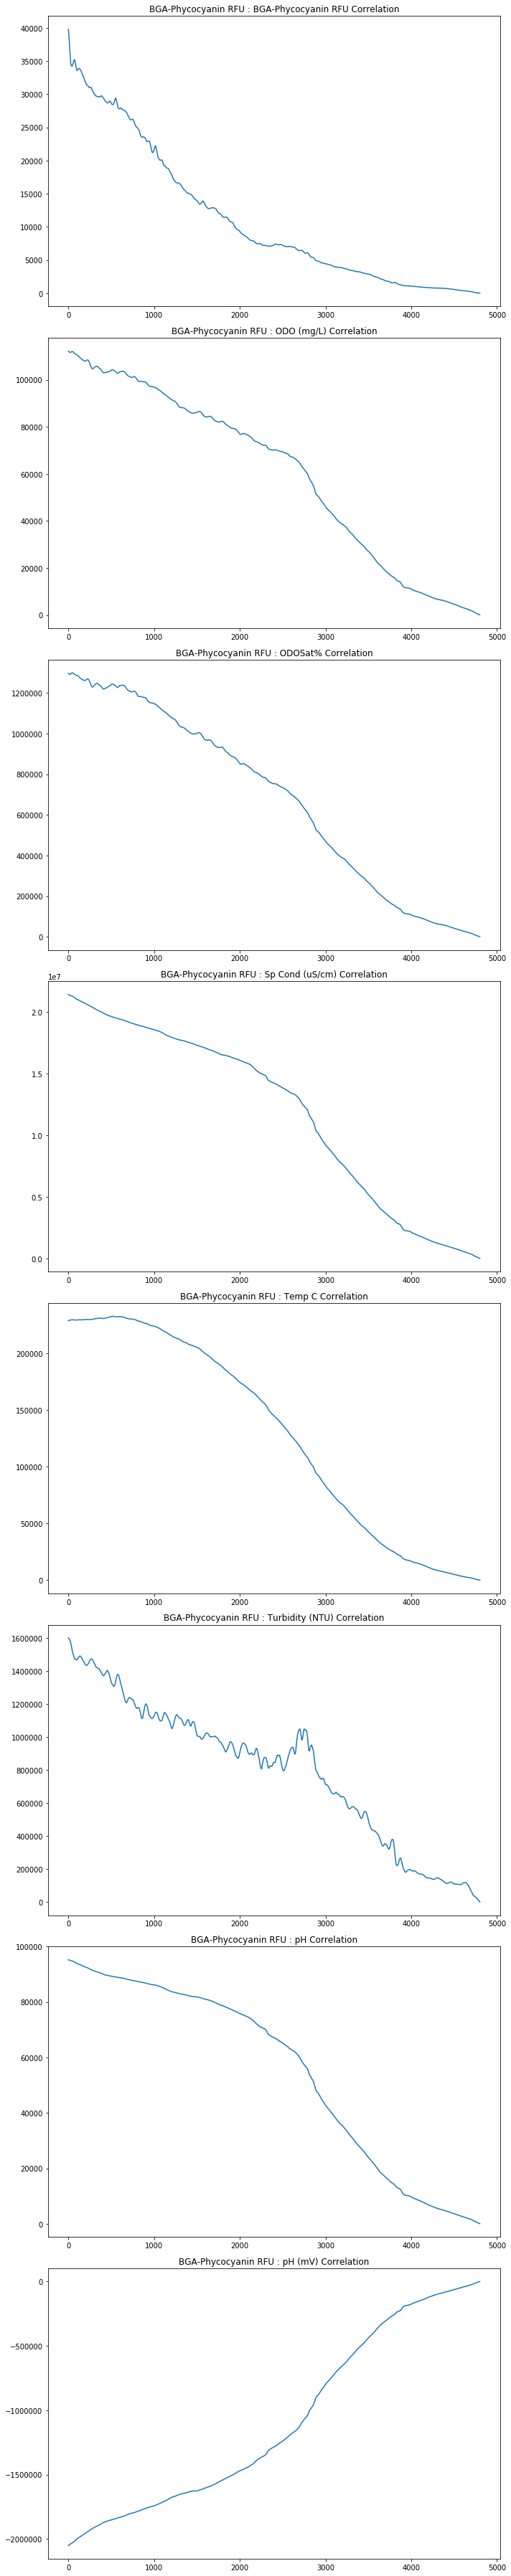

In [16]:
hf.create_correlation_plots(test_dfs[test_index].drop(columns=['datetime']), 
                           target_column)

## BGA RFU Levels

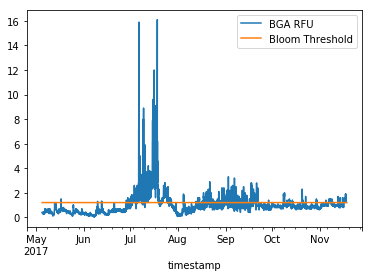

In [17]:
presegmented_plot.plot.line()

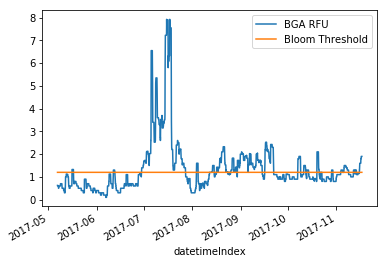

In [18]:
pd.DataFrame({'BGA RFU': train_dfs[train_index][target_column], 
            'Bloom Threshold': np.full(
                train_dfs[train_index].count()[0], RFU_THRESHOLD)}).plot.line()

In [19]:
lrf.add_target_column([train_dfs[train_index], test_dfs[test_index]], 
                      threshold=RFU_THRESHOLD)

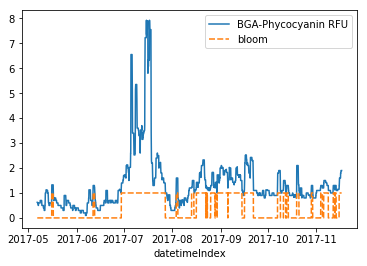

In [20]:
sns.lineplot(data=train_dfs[train_index][[target_column, 'bloom']], hue='bloom')

## Logistic Regression Model

### Null Model

In [21]:
# The null model's performance
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom', True)
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", train_dfs[train_index].columns)

Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]
columns: Index(['BGA-Phycocyanin RFU', 'ODO (mg/L)', 'ODOSat%', 'Sp Cond (uS/cm)',
       'Temp C', 'Turbidity (NTU)', 'datetime', 'pH', 'pH (mV)',
       'Temp C_4_bins', 'Sp Cond (uS/cm)_4_bins', 'pH (mV)_4_bins',
       'pH_4_bins', 'Turbidity (NTU)_4_bins', 'ODOSat%_4_bins',
       'ODO (mg/L)_4_bins', 'bloom'],
      dtype='object')


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### All variables model

In [22]:
# All variables model performance
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", x_columns)

Accuracy 0.5932097479691731
Recall: 0.9748743718592965
Precision 0.5905631659056316
Confusion Matrix:
 [[ 132 1883]
 [  70 2716]]
columns: ['Turbidity (NTU)_4_bins', 'pH', 'ODOSat%', 'ODOSat%_4_bins', 'pH (mV)', 'ODO (mg/L)_4_bins', 'Temp C_4_bins', 'ODO (mg/L)', 'Turbidity (NTU)', 'pH_4_bins', 'Sp Cond (uS/cm)', 'Sp Cond (uS/cm)_4_bins', 'Temp C', 'pH (mV)_4_bins']


### Best model to date

In [23]:
max_iter = 25000
loss = "log"
base_columns = ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)']
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], base_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", base_columns)

Accuracy 0.7865028119141846
Recall: 0.8851399856424982
Precision 0.7776726584673604
Confusion Matrix:
 [[1310  705]
 [ 320 2466]]
columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)']


### Greedy Model

In [24]:
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
# Sort columns by accuracy
sorted_columns = lrf.sort_columns_by_metric(model, train_dfs[train_index], 
                                            test_dfs[test_index],
                                            x_columns,
                                            'bloom')

Training model with: Turbidity (NTU)_4_bins


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

Training model with: pH
Accuracy 0.6854821912101645
Recall: 0.9178033022254127
Precision 0.6662324127149557
Confusion Matrix:
 [[ 734 1281]
 [ 229 2557]]

Training model with: ODOSat%
Accuracy 0.7167256821495521
Recall: 0.6920315865039484
Precision 0.7934156378600823
Confusion Matrix:
 [[1513  502]
 [ 858 1928]]

Training model with: ODOSat%_4_bins
Accuracy 0.7156842324515726
Recall: 0.7135678391959799
Precision 0.7780821917808219
Confusion Matrix:
 [[1448  567]
 [ 798 1988]]

Training model with: pH (mV)
Accuracy 0.5802957717142262
Recall: 1.0
Precision 0.5802957717142262
Confusion Matrix:
 [[   0 2015]
 [   0 2786]]

Training model with: ODO (mg/L)_4_bins
Accuracy 0.6192459904186628
Recall: 0.38190954773869346
Precision 0.9094017094017094
Confusion Matrix:
 [[1909  106]
 [1722 1064]]

Training model with: Temp C_4_bins
Accuracy 0.6034159550093731
Recall: 0.4335965541995693
Precision 0

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

Training model with: pH_4_bins
Accuracy 0.757550510310352
Recall: 0.7616654702081838
Precision 0.8093058733790999
Confusion Matrix:
 [[1515  500]
 [ 664 2122]]

Training model with: Sp Cond (uS/cm)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

Training model with: Sp Cond (uS/cm)_4_bins


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

Training model with: Temp C
Accuracy 0.6059154342845241
Recall: 0.416367552045944
Precision 0.8134642356241234
Confusion Matrix:
 [[1749  266]
 [1626 1160]]

Training model with: pH (mV)_4_bins
Accuracy 0.6434076234117893
Recall: 0.45908111988514
Precision 0.8618598382749326
Confusion Matrix:
 [[1810  205]
 [1507 1279]]

pH_4_bins metric value: 0.757550510310352
ODOSat% metric value: 0.7167256821495521
ODOSat%_4_bins metric value: 0.7156842324515726
ODO (mg/L) metric value: 0.7042282857737971
pH metric value: 0.6854821912101645
pH (mV)_4_bins metric value: 0.6434076234117893
ODO (mg/L)_4_bins metric value: 0.6192459904186628
Temp C metric value: 0.6059154342845241
Temp C_4_bins metric value: 0.6034159550093731
pH (mV) metric value: 0.5802957717142262
Turbidity (NTU)_4_bins metric value: 0.4197042282857738
Turbidity (NTU) metric value: 0.4197042282857738
Sp Cond (uS/cm) metric value: 0.4

In [25]:
#create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)

accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 
                                            'bloom', sorted_columns)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


greedy_columns: []
sorted_columns: ['pH_4_bins', 'ODOSat%', 'ODOSat%_4_bins', 'ODO (mg/L)', 'pH', 'pH (mV)_4_bins', 'ODO (mg/L)_4_bins', 'Temp C', 'Temp C_4_bins', 'pH (mV)', 'Turbidity (NTU)_4_bins', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'Sp Cond (uS/cm)_4_bins']
adjusted sorted_columns: ['pH_4_bins', 'ODOSat%', 'ODOSat%_4_bins', 'ODO (mg/L)', 'pH', 'pH (mV)_4_bins', 'ODO (mg/L)_4_bins', 'Temp C', 'Temp C_4_bins', 'pH (mV)', 'Turbidity (NTU)_4_bins', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'Sp Cond (uS/cm)_4_bins']
Training model with: ['pH_4_bins']
Test model accuracy: 0.757550510310352
Test model recall: 0.7616654702081838
Test model precision: 0.8093058733790999

Updating greedy model

Training model with: ['pH_4_bins', 'ODOSat%']
Test model accuracy: 0.7363049364715685
Test model recall: 0.7214644651830582
Test model precision: 0.804

Training model with: ['pH_4_bins', 'ODOSat%_4_bins']
Test model accuracy: 0.7242241199750052
Test model recall: 0.6486001435750179
Test model precisio

Model AUC: 0.7544


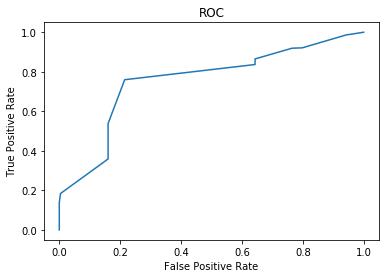

In [26]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_dfs[test_index][['bloom']].values, predictions)

### Greedy Model With Base Columns

In [27]:
#create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)

accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 
                                            'bloom', sorted_columns, base_columns)


greedy_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)']
sorted_columns: ['pH_4_bins', 'ODOSat%', 'ODOSat%_4_bins', 'ODO (mg/L)', 'pH', 'pH (mV)_4_bins', 'ODO (mg/L)_4_bins', 'Temp C', 'Temp C_4_bins', 'pH (mV)', 'Turbidity (NTU)_4_bins', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'Sp Cond (uS/cm)_4_bins']
adjusted sorted_columns: ['pH_4_bins', 'ODOSat%_4_bins', 'pH (mV)_4_bins', 'ODO (mg/L)_4_bins', 'Temp C_4_bins', 'pH (mV)', 'Turbidity (NTU)_4_bins', 'Turbidity (NTU)', 'Sp Cond (uS/cm)_4_bins']
Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)', 'pH_4_bins']
Test model accuracy: 0.7860862320349927
Test model recall: 0.8916008614501076
Test model precision: 0.7740729199127454

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)', 'ODOSat%_4_bins']
Test model accuracy: 0.7758800249947928
Test model recall: 0.8797559224694903
Test model precision: 0.7678571428571429

Training model with: ['ODOSat%', 'ODO (mg/L)', 

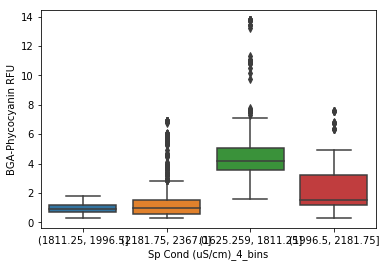

In [28]:
# Using the base model as a starting point the model seems to have improved.
# Charting the bin categories selected:
sns.boxplot(data=test_dfs[test_index], 
            x='Sp Cond (uS/cm)_4_bins',
           y=target_column)

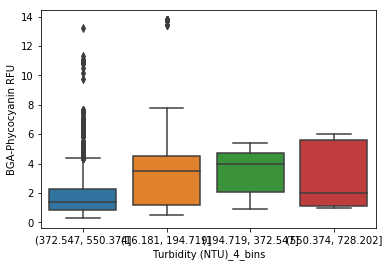

In [29]:
# Using the base model as a starting point the model seems to have improved.
# Charting the bin categories selected:
sns.boxplot(data=test_dfs[test_index], 
            x='Turbidity (NTU)_4_bins',
           y=target_column)

## Random Forest Model

In [30]:
# All Inputs
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

Accuracy 0.7527598416996459
Recall: 0.8481694185211773
Precision 0.7556763671250399
Confusion Matrix:
 [[1251  764]
 [ 423 2363]]
